### Weather API
#### Yearly Precipitation Data Retrieval

This notebook uses the OpenMeteo Weather Archive API to retrieve past weather data for any given coordinates. It aims to provide an interface that will retrieve info on year to year weather data that aligns with the yearly measures from the International Tree Ring Datasets (https://www.ncei.noaa.gov/products/paleoclimatology/tree-ring) to measure the correlation between tree ring width and precipitation.

First, we need to install the OpenMeteo Python wrapper, under the hood this just uses the requests library, so we can setup a requests-cache and retry configurations such that the success rate of our querying class is more reliable and faster for multiple calls on the same years.

In [1]:
!pip install openmeteo-requests

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install requests-cache retry-requests

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [33]:
import pandas as pd
import numpy as np
from typing import List, Tuple
import requests_cache
from retry_requests import retry
from datetime import datetime
import openmeteo_requests

This is the main part of the Notebook. The WeatherAPI class comes with one public method: `get_yearly_precipitation()`. It is documented as follows:

```
get_yearly_precipitation(year_start: int, year_end: int, longitude_latitude: Tuple, verbose=False)

Takes in parameters:

year_start: int -> Year to start measurement (inclusive)
year_end: int -> Year to end measurement (inclusive)
longitude_latitude: Tuple -> A 2 element tuple, whose first element is Longitude (int) and second is Latitude (int)
verbose (default False): bool -> Print debug info flag

The function uses the parameters to form a Pandas DataFrame that models precipitation overall sum, average, min, and max per year.
The Dataframe contains the following columns holding the above info:

year
precipitation_sum (in mm)
precipitation_daily_avg (in mm)
precipitation_min (in mm)
precipitation_max (in mm)

```

The class makes it so only one Request to the API is made, hopefully helping to speed up the Pipeline. Usually, the OpenMeteo API would only give you up to every day in a year, not info on the overall year, meaning you'd have to make multiple requests for each year. By only making 1 call we're significantly reducing the wait time due to network calls to the API. It does this by creating intervals over each year to process info for only a subset of the data that correlates to each year. Then, it just uses this calculated info to create a DataFrame and return it to the caller.

In [120]:
class WeatherAPI:
    
    
    def __init__(self, expire_after=-1, retries=5, backoff_factor=.2):
    
        # Create Session with OpenMeteo, establish Endpoint
        self.cache = requests_cache.CachedSession('.cache', expire_after=expire_after)
        self.OpenMeteo = openmeteo_requests.Client(session=retry(self.cache, retries=retries, backoff_factor=backoff_factor))
        self.endpoint = "https://archive-api.open-meteo.com/v1/archive"
    
    
    def __process_dates(self, year_start: int, year_end: int) -> List[Tuple[int, int]]:
    
        f = "%m/%d/%Y"
        dates_list = [
            (int(datetime.strptime(f"01/01/{i}", f).timestamp()), int(datetime.strptime(f"12/31/{i}", f).timestamp())) for i in range(year_start, year_end+1)
        ]
    
        return dates_list
    
    
    def __send_request(self, packet: dict, verbose=False) -> pd.DataFrame:
    
        reponse = None
        df = pd.DataFrame()
        start_year, end_year = packet['year_start'], packet['year_end']
        dates = self.__process_dates(start_year, end_year)
        packet['start_date'] = f"{packet['year_start']}-01-01"
        packet['end_date'] = f"{packet['year_end']}-12-31"
    
        if verbose:
            print(packet)
    
        try:
            responses = self.OpenMeteo.weather_api(self.endpoint, params=packet)
        except Exception as e:
            if verbose:
                print(e)
            return df
    
        if verbose:
            
            print(f"Coordinates {responses[0].Longitude()}°E {responses[0].Latitude()}°N")
            print(f"Elevation {responses[0].Elevation()} m asl")
            print(f"Timezone {responses[0].Timezone()} {responses[0].TimezoneAbbreviation()}")
            print(f"Timezone difference to GMT+0 {responses[0].UtcOffsetSeconds()} s")

        main_df = pd.DataFrame(columns=[
            'year', 
            "precipitation_sum",
            "precipitation_avg",
            "precipitation_min",
            "precipitation_max",
            "temperature_sum",
            "temperature_avg",
            "temperature_min",
            "temperature_max"
        ])

        count = 0
        for response in responses:
            daily = response.Daily()
            temperature = daily.Variables(0).ValuesAsNumpy()
            print(temperature)
            precip = daily.Variables(1).ValuesAsNumpy()
            print(precip)
            
    
            last_ind = 0
            df_data = {
                "year": [],
                "precipitation_sum": [],
                "precipitation_avg": [],
                "precipitation_min": [],
                "precipitation_max": [],
                "temperature_sum": [],
                "temperature_avg": [],
                "temperature_min": [],
                "temperature_max": []
            }
    
            for i in range(0, end_year-start_year+1):
    
                days = len(pd.date_range(
                    start = pd.to_datetime(dates[i][0], unit = "s"),
                    end = pd.to_datetime(dates[i][1], unit = "s"),
                    freq = pd.Timedelta(seconds = 86400),
                    inclusive = "left"
                ))

    
                years_data = precip[last_ind:days+last_ind]
                temp_data = temperature[last_ind:days+last_ind]
                df_data["year"].append(i+start_year)
                df_data["precipitation_sum"].append(years_data.sum())
                df_data["precipitation_avg"].append(np.mean(years_data))
                df_data["precipitation_min"].append(np.min(years_data))
                df_data["precipitation_max"].append(np.max(years_data))
                df_data["temperature_sum"].append(temp_data.sum())
                df_data["temperature_avg"].append(np.mean(temp_data))
                df_data["temperature_min"].append(np.min(temp_data))
                df_data["temperature_max"].append(np.max(temp_data))
                
    
                last_ind=days+last_ind
    
            dataframe = pd.DataFrame(data=df_data)
            dataframe['lat'] = packet['latitude'][count]
            dataframe['lon'] = packet['longitude'][count]
            main_df = pd.concat([main_df, dataframe], ignore_index=True)
            count+=1

        print(main_df)
        return main_df
    
    
    def get_yearly_precipitation(self, year_start: int, year_end: int, long_lat: Tuple, verbose=False) -> pd.DataFrame:

        lats = [i[0] for i in long_lat]
        lons = [i[1] for i in long_lat]
        return self.__send_request({
            "latitude": lats,
            "longitude": lons,
            "year_start": year_start,
            "year_end": year_end,
            "daily": ["temperature_2m_mean", "precipitation_sum"]
        }, verbose=verbose)

Now all we need is an instance of this class. You can modify the default values in the constructor to adjust settings about how the class interacts with the API:

expire_after: how long after the request is made to stop the waiting and return an expired request (default -1, or inifinite, to let OpenMeteo handle that)

retries: how many times to retry a failed request (default 5)

backoff_factor: adjust the backoff factor of the requests being sent out to OpenMeteo (default .2)

Let's test it on the years from 1970-2022 in Berlin:

In [141]:
df = pd.read_csv('/mnt/c/Users/Michael Anderson/Desktop/random_latlong.csv')

In [142]:
df = df[['Latitude', 'Longitude']]

In [143]:
lats = list(df['Latitude'])
longs = list(df['Longitude'])

In [144]:
seen = set()
out = []
for i in range(len(lats)):
    lat_cur = lats[i]
    lon_cur = longs[i]

    if (lat_cur, lon_cur) not in seen:
        out.append((lat_cur, lon_cur))
        seen.add((lat_cur, lon_cur))

In [145]:
print(len(out))

115


In [146]:
Weather = WeatherAPI()
df = Weather.get_yearly_precipitation(1941, 1991, out, verbose=True)

{'latitude': [42.90106471874291, 43.897234585733294, 44.66626254311422, 42.865496123606114, 45.5760317376105, 31.62953062571996, 30.825607236329827, 34.47364119685824, 32.10032541214999, 33.78342300707467, 35.03940240434609, 35.43159449907531, 39.11156418432981, 35.776655530834375, 38.95096244009836, 36.074775876345456, 38.041587561509125, 39.96168505673288, 38.7640450966794, 38.593735253626924, 39.84247383456071, 39.29795499093727, 39.155139686979446, 39.1646790677368, 39.15565209770326, 36.36064540991926, 39.6876530137563, 37.74452722641566, 40.06199062630843, 38.436482345342334, 36.54042703983284, 37.758987916034506, 37.52857993921843, 39.8298849592765, 39.49124230687419, 38.90429409981154, 39.01417618902878, 41.494866812815424, 39.17667918895246, 40.60958720106364, 40.45902244523887, 38.05851637735794, 38.260370535484064, 40.15705040131768, 40.91643138830783, 37.96223350119752, 37.064601570645, 39.62701933936821, 39.58853270307674, 40.426164858452125, 38.745352011991976, 40.4027497

/tmp/ipykernel_6056/1185018757.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  main_df = pd.concat([main_df, dataframe], ignore_index=True)


[-11.536751  -14.490917  -14.728417  ...  -7.639667  -10.781334
  -7.0730004]
[0.2 0.  0.  ... 0.  0.  0. ]
[-6.3138337 -9.053415  -8.447167  ... -5.858167  -7.547751  -5.901918 ]
[0. 0. 0. ... 0. 0. 0.]
[2.8434165 2.63925   1.658     ... 3.4865    3.6135836 3.2698333]
[0.6 0.2 0.  ... 0.  0.  0. ]
[8.049834 8.410249 6.79775  ... 8.7025   8.077499 7.098333]
[0.9000001 0.        0.        ... 0.        0.        0.       ]
[4.3036666 3.7140837 3.214083  ... 5.3139167 4.4264174 2.2493331]
[ 0.        0.        0.       ...  2.2      12.099999  0.9     ]
[6.825584  5.5485    4.000583  ... 6.2919173 6.689833  4.9523335]
[3.2000003 0.        0.        ... 0.        0.        0.1      ]
[-2.99975   -5.39975   -6.8268337 ... -1.8458333 -2.1562502 -4.7270837]
[2.3999996 0.2       0.2       ... 1.7000002 4.6       1.2      ]
[ 9.384416  12.944833   6.5302505 ...  6.5505834  5.8422503  4.4610004]
[1.9       7.5999994 0.        ... 0.        0.        0.       ]
[12.224666  10.605916   5.3892503 

In [147]:
df

,year,precipitation_sum,precipitation_avg,precipitation_min,precipitation_max,temperature_sum,temperature_avg,temperature_min,temperature_max,lat,lon
0,1941,491.299988,1.349725,0.0,20.799999,1164.860596,3.200166,-16.806833,23.526497,42.901065,-112.084051
1,1942,534.500000,1.468407,0.0,17.299999,927.408569,2.547826,-24.792252,21.316084,42.901065,-112.084051
2,1943,500.000000,1.373626,0.0,24.499998,1242.308472,3.412935,-22.302666,22.901503,42.901065,-112.084051
3,1944,552.500000,1.513699,0.0,16.900000,945.855957,2.591386,-16.467249,20.266085,42.901065,-112.084051
4,1945,765.999939,2.098630,0.0,20.600000,785.907837,2.153172,-19.648502,21.930670,42.901065,-112.084051
...,...,...,...,...,...,...,...,...,...,...,...
5860,1987,367.600006,1.009890,0.0,33.600002,5285.867188,14.521613,-6.397583,28.875330,32.348912,-108.431940
5861,1988,514.299988,1.409041,0.0,31.400003,5359.813477,14.684421,-11.737167,28.085749,32.348912,-108.431940
5862,1989,265.299988,0.728846,0.0,16.300003,5892.385742,16.187874,-2.066333,30.708666,32.348912,-108.431940
5863,1990,394.599976,1.084066,0.0,27.500000,5552.996094,15.255484,-3.170500,32.462833,32.348912,-108.431940


In [225]:
df['lat'].unique()

array([43.23    , 42.75    , 43.7     , 43.75    , 43.32    , 42.93    ,
       42.78    , 43.62    , 43.73    , 44.58    , 43.47    , 43.08    ,
       45.97    , 33.05    , 32.7     , 45.47    , 45.28    , 39.2988  ,
       32.72    , 39.2583  , 45.55    , 45.      , 45.83    , 45.12    ,
       47.34    , 48.51    , 44.13    , 48.18    , 45.82    , 48.59    ,
       48.6     , 46.7     , 45.77    , 36.13    , 45.68    , 48.78    ,
       32.8     , 39.93    , 33.355   , 39.5     , 36.8     , 40.98    ,
       40.67    , 40.05    , 42.63    , 37.216667, 41.52    , 40.37    ,
       32.      , 39.38    , 37.47    , 40.25    , 39.68    , 39.55    ,
       38.87    , 36.07    , 32.334   , 36.6167  , 40.72    , 38.32    ,
       38.53    , 36.159   ])

In [75]:
df1 = pd.read_csv('/mnt/c/Users/Michael Anderson/Desktop/main_weather.csv')

In [148]:
df.to_csv('./random_weather.csv')

In [78]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

DataFrame looks good, now we can plot the data we have retrieved:

In [79]:
df2

,year,precipitation_sum,precipitation_avg,precipitation_min,precipitation_max,temperature_sum,temperature_avg,temperature_min,temperature_max,lat,lon
0,1941,795.199950,2.184615,0.0,32.600000,-1039.520100,-2.855825,-22.764832,16.620583,45.1667,-109.5167
1,1942,796.500000,2.188187,0.0,24.199999,-1279.340800,-3.514673,-28.835660,15.106002,45.1667,-109.5167
2,1943,740.000000,2.032967,0.0,25.300001,-893.180660,-2.453793,-29.969000,15.399751,45.1667,-109.5167
3,1944,741.400000,2.031233,0.0,25.500000,-954.928830,-2.616243,-22.046083,14.287251,45.1667,-109.5167
4,1945,878.100040,2.405754,0.0,30.000000,-1328.664100,-3.640176,-24.752329,14.799747,45.1667,-109.5167
...,...,...,...,...,...,...,...,...,...,...,...
18661,1987,771.300049,2.118956,0.0,24.699999,2490.460449,6.841924,-23.084665,26.373665,46.8600,-87.8000
18662,1988,1014.000000,2.778082,0.0,53.599998,2107.953125,5.775214,-21.743002,29.094503,46.8600,-87.8000
18663,1989,843.500000,2.317308,0.0,34.400002,1911.473022,5.251299,-23.851334,26.900751,46.8600,-87.8000
18664,1990,896.399963,2.462637,0.0,44.700001,1963.868774,5.395244,-19.890917,24.459082,46.8600,-87.8000


In [76]:
df2 = pd.concat([df1, df], ignore_index=True)

In [80]:
df2.to_csv('./main_weather.csv')

In [ ]:
import matplotlib.pyplot as plt

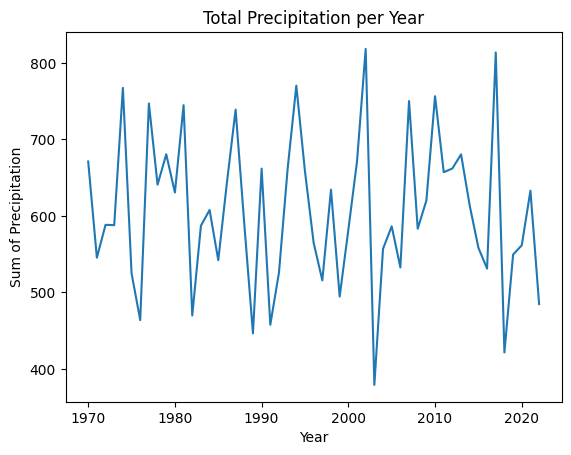

In [ ]:
plt.plot(df['year'], df['precipitation_sum'])
plt.xlabel('Year')
plt.ylabel('Sum of Precipitation')
plt.title('Total Precipitation per Year')
plt.show()

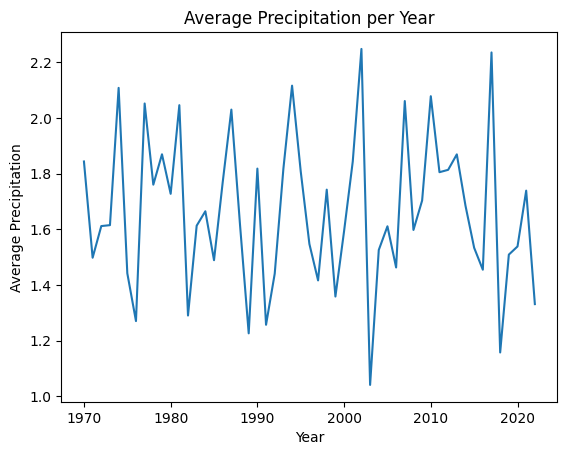

In [ ]:
plt.plot(df['year'], df['precipitation_daily_avg'])
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.title('Average Precipitation per Year')
plt.show()

In [226]:
df.to_csv('./weather_4.csv')

In [227]:
df = pd.read_csv('./weather_1.csv')
df1 = pd.read_csv('./weather_2.csv')
df2 = pd.read_csv('./weather_3.csv')
df3 = pd.read_csv('./weather_4.csv')

In [228]:
df

,Unnamed: 0,year,precipitation_sum,precipitation_avg,precipitation_min,precipitation_max,temperature_sum,temperature_avg,temperature_min,temperature_max,lat,lon
0,0,1941,795.19995,2.184615,0.0,32.600000,-1039.52010,-2.855825,-22.764832,16.620583,45.1667,-109.5167
1,1,1942,796.50000,2.188187,0.0,24.199999,-1279.34080,-3.514673,-28.835660,15.106002,45.1667,-109.5167
2,2,1943,740.00000,2.032967,0.0,25.300001,-893.18066,-2.453793,-29.969000,15.399751,45.1667,-109.5167
3,3,1944,741.40000,2.031233,0.0,25.500000,-954.92883,-2.616243,-22.046083,14.287251,45.1667,-109.5167
4,4,1945,878.10004,2.405754,0.0,30.000000,-1328.66410,-3.640176,-24.752329,14.799747,45.1667,-109.5167
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,5095,1987,593.60000,1.630769,0.0,17.400002,419.07250,1.151298,-20.446000,17.837330,38.8000,-106.2300
5096,5096,1988,651.20000,1.784110,0.0,21.500000,420.59094,1.152304,-23.462670,16.508165,38.8000,-106.2300
5097,5097,1989,563.50000,1.548077,0.0,20.999998,397.25586,1.091362,-23.102247,19.541498,38.8000,-106.2300
5098,5098,1990,688.40000,1.891209,0.0,45.599995,439.66223,1.207863,-21.202251,19.987333,38.8000,-106.2300


In [56]:
df.to_csv('./oaks.csv')

In [230]:
df

,Unnamed: 0,year,precipitation_sum,precipitation_avg,precipitation_min,precipitation_max,temperature_sum,temperature_avg,temperature_min,temperature_max,lat,lon
0,0,1941,795.19995,2.184615,0.0,32.600000,-1039.52010,-2.855825,-22.764832,16.620583,45.1667,-109.5167
1,1,1942,796.50000,2.188187,0.0,24.199999,-1279.34080,-3.514673,-28.835660,15.106002,45.1667,-109.5167
2,2,1943,740.00000,2.032967,0.0,25.300001,-893.18066,-2.453793,-29.969000,15.399751,45.1667,-109.5167
3,3,1944,741.40000,2.031233,0.0,25.500000,-954.92883,-2.616243,-22.046083,14.287251,45.1667,-109.5167
4,4,1945,878.10004,2.405754,0.0,30.000000,-1328.66410,-3.640176,-24.752329,14.799747,45.1667,-109.5167
...,...,...,...,...,...,...,...,...,...,...,...,...
18559,3259,1987,663.10000,1.821703,0.0,22.300001,2280.62450,6.265452,-13.539165,20.821253,36.1590,-105.5940
18560,3260,1988,742.30000,2.033699,0.0,19.600002,2105.17720,5.767609,-16.501665,19.696249,36.1590,-105.5940
18561,3261,1989,738.10004,2.027747,0.0,26.600002,2474.67680,6.798563,-16.466250,21.798334,36.1590,-105.5940
18562,3262,1990,700.80000,1.925275,0.0,19.100002,2437.53080,6.696513,-14.693333,22.475420,36.1590,-105.5940


In [231]:
df.to_csv('./main_weather.csv')

In [232]:
df = pd.read_csv('/mnt/c/Users/Michael Anderson/Desktop/main_weather.csv')

In [132]:
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [233]:
df

,year,precipitation_sum,precipitation_avg,precipitation_min,precipitation_max,temperature_sum,temperature_avg,temperature_min,temperature_max,lat,lon
0,1941,795.19995,2.184615,0,32.600000,-1039.52010,-2.855825,-22.764832,16.620583,45.1667,-109.5167
1,1942,796.50000,2.188187,0,24.199999,-1279.34080,-3.514673,-28.835660,15.106002,45.1667,-109.5167
2,1943,740.00000,2.032967,0,25.300001,-893.18066,-2.453793,-29.969000,15.399751,45.1667,-109.5167
3,1944,741.40000,2.031233,0,25.500000,-954.92883,-2.616243,-22.046083,14.287251,45.1667,-109.5167
4,1945,878.10004,2.405754,0,30.000000,-1328.66410,-3.640176,-24.752329,14.799747,45.1667,-109.5167
...,...,...,...,...,...,...,...,...,...,...,...
18559,1987,663.10000,1.821703,0,22.300001,2280.62450,6.265452,-13.539165,20.821253,36.1590,-105.5940
18560,1988,742.30000,2.033699,0,19.600002,2105.17720,5.767609,-16.501665,19.696249,36.1590,-105.5940
18561,1989,738.10004,2.027747,0,26.600002,2474.67680,6.798563,-16.466250,21.798334,36.1590,-105.5940
18562,1990,700.80000,1.925275,0,19.100002,2437.53080,6.696513,-14.693333,22.475420,36.1590,-105.5940


In [136]:
df.to_csv('main_weather.csv')

In [138]:
df = pd.read_csv('main_weather.csv')
df

,Unnamed: 0,year,precipitation_sum,precipitation_daily_avg,precipitation_min,lat,lon,precipitation_max
0,0,1970,938.90000,2.579396,0.0,45.1667,-109.5167,25.600000
1,1,1971,1003.60000,2.757143,0.0,45.1667,-109.5167,30.999998
2,2,1972,980.69995,2.686849,0.0,45.1667,-109.5167,19.099998
3,3,1973,911.80000,2.504945,0.0,45.1667,-109.5167,26.700000
4,4,1974,962.70000,2.644780,0.0,45.1667,-109.5167,36.600000
...,...,...,...,...,...,...,...,...
7639,7639,1986,839.50000,2.306319,0.0,36.1590,-105.5940,26.900000
7640,7640,1987,652.10000,1.791483,0.0,36.1590,-105.5940,18.200000
7641,7641,1988,730.40000,2.001096,0.0,36.1590,-105.5940,19.600002
7642,7642,1989,731.80005,2.010440,0.0,36.1590,-105.5940,26.600002


In [ ]:
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [44]:
df = pd.read_csv('/mnt/c/Users/Michael Anderson/Desktop/merged_oaks.csv')

In [46]:
df.drop(columns=[str(i) for i in range(1, 1941)], axis=1, inplace=True)

In [47]:
df = df.dropna(how='any')

In [48]:
df
#936 maples
#1906 firs
#6313 oaks

,index,1941,1942,1943,1944,1945,1946,1947,1948,1949,...,1989,1990,1991,site,loc,N,S,E,W,species
46,067011_raw,0.970,1.090,1.110,1.070,1.130,1.280,1.080,1.150,1.240,...,1.260,1.260,0.930,Fernow Experimental Forest,West Virginia,39.10,39.10,-79.72,-79.72,QUPR
47,084041_raw,2.780,3.060,2.590,2.270,2.060,2.590,1.540,1.660,2.110,...,1.070,1.170,1.060,Fernow Experimental Forest,West Virginia,39.10,39.10,-79.72,-79.72,QUPR
48,065021_raw,3.510,4.160,3.010,3.030,3.360,3.180,2.840,2.540,3.420,...,1.200,1.320,1.210,Fernow Experimental Forest,West Virginia,39.10,39.10,-79.72,-79.72,QUPR
49,078031_raw,2.350,3.080,1.730,3.310,2.350,3.110,1.920,1.610,2.300,...,1.880,2.350,1.690,Fernow Experimental Forest,West Virginia,39.10,39.10,-79.72,-79.72,QUPR
50,070021_raw,1.570,2.000,1.520,1.720,1.370,1.880,1.630,1.880,2.360,...,0.860,0.870,0.750,Fernow Experimental Forest,West Virginia,39.10,39.10,-79.72,-79.72,QUPR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13359,TVR19b_raw,0.955,0.996,1.257,1.170,1.597,1.324,1.354,1.015,0.860,...,1.106,1.044,0.713,Goose Egg Ridge,New York,43.09,43.09,-73.39,-73.39,QURU
13360,TVR20a_raw,0.881,1.008,0.863,1.089,1.561,1.227,1.363,1.140,1.131,...,1.800,1.397,1.288,Goose Egg Ridge,New York,43.09,43.09,-73.39,-73.39,QURU
13361,TVR20b_raw,1.082,1.440,1.281,1.776,1.511,1.464,1.360,1.255,1.037,...,2.208,1.593,1.537,Goose Egg Ridge,New York,43.09,43.09,-73.39,-73.39,QURU
13362,TVR21a_raw,0.860,0.910,1.133,1.126,1.197,1.190,1.291,1.094,0.785,...,1.218,0.893,0.762,Goose Egg Ridge,New York,43.09,43.09,-73.39,-73.39,QURU


In [49]:
df[['N', 'E']]

,N,E
46,39.10,-79.72
47,39.10,-79.72
48,39.10,-79.72
49,39.10,-79.72
50,39.10,-79.72
...,...,...
13359,43.09,-73.39
13360,43.09,-73.39
13361,43.09,-73.39
13362,43.09,-73.39


In [ ]:
df